In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from functools import reduce
import calendar


In [2]:
df = pd.read_csv('hotel_bookings_clean.csv', parse_dates=['arrival_date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118087 entries, 0 to 118086
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118087 non-null  object        
 1   is_canceled                     118087 non-null  bool          
 2   lead_time                       118087 non-null  int64         
 3   arrival_date_month              118087 non-null  object        
 4   stays_in_weekend_nights         118087 non-null  int64         
 5   stays_in_week_nights            118087 non-null  int64         
 6   adults                          118087 non-null  int64         
 7   children                        118087 non-null  int64         
 8   babies                          118087 non-null  int64         
 9   meal                            118087 non-null  object        
 10  market_segment                  118087 non-null  object 

In [4]:
print(df['reservation_status'].value_counts())

reservation_status
Check-Out    73973
Canceled     42925
No-Show       1189
Name: count, dtype: int64


In [5]:
cancelations = (df['reservation_status'] == 'Canceled').sum()
print(cancelations)

42925


In [6]:
total_bookings = df.shape[0]
print(total_bookings)

118087


In [7]:
cancelation_rate = cancelations / total_bookings
print(cancelation_rate)

0.36350317985891756


/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


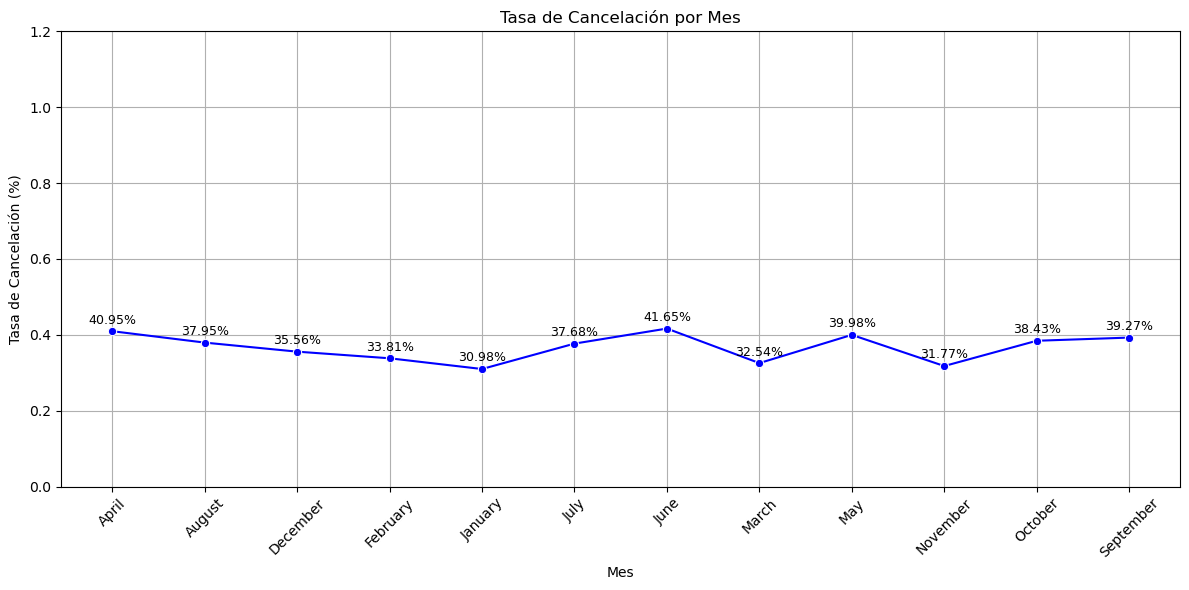

In [8]:
# Asegurar que 'arrival_date_month' sea el índice correcto para la gráfica
monthly_cancellation = df.groupby("arrival_date_month", observed=True).agg(
    total_bookings=("is_canceled", "count"), 
    cancellations=("is_canceled", "sum")
)
monthly_cancellation["cancellation_rate"] = (monthly_cancellation["cancellations"] / monthly_cancellation["total_bookings"])

# Paso 3: Visualización con ajuste de índice
plt.figure(figsize=(12, 6))

# Dibujar la línea con marcadores
sns.lineplot(data=monthly_cancellation, x=monthly_cancellation.index, y="cancellation_rate", marker="o", color="blue")

# Añadir etiquetas de porcentaje encima de cada punto
for i in range(len(monthly_cancellation)):
    porcentaje = monthly_cancellation['cancellation_rate'].iloc[i] * 100  # Usar .iloc para acceder por posición
    plt.text(
        x=monthly_cancellation.index[i],
        y=monthly_cancellation['cancellation_rate'].iloc[i] + 0.02,  # Ajuste vertical
        s=f"{porcentaje:.2f}%",  # Formato porcentaje con 2 decimales
        ha='center',
        fontsize=9,
        color='black'
    )

# Personalización del gráfico
plt.title("Tasa de Cancelación por Mes")
plt.ylabel("Tasa de Cancelación (%)")
plt.xlabel("Mes")
plt.xticks(rotation=45)
plt.ylim(0, 1.2)  # Dejar espacio para etiquetas
plt.grid(True)
plt.tight_layout()
plt.show()


/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

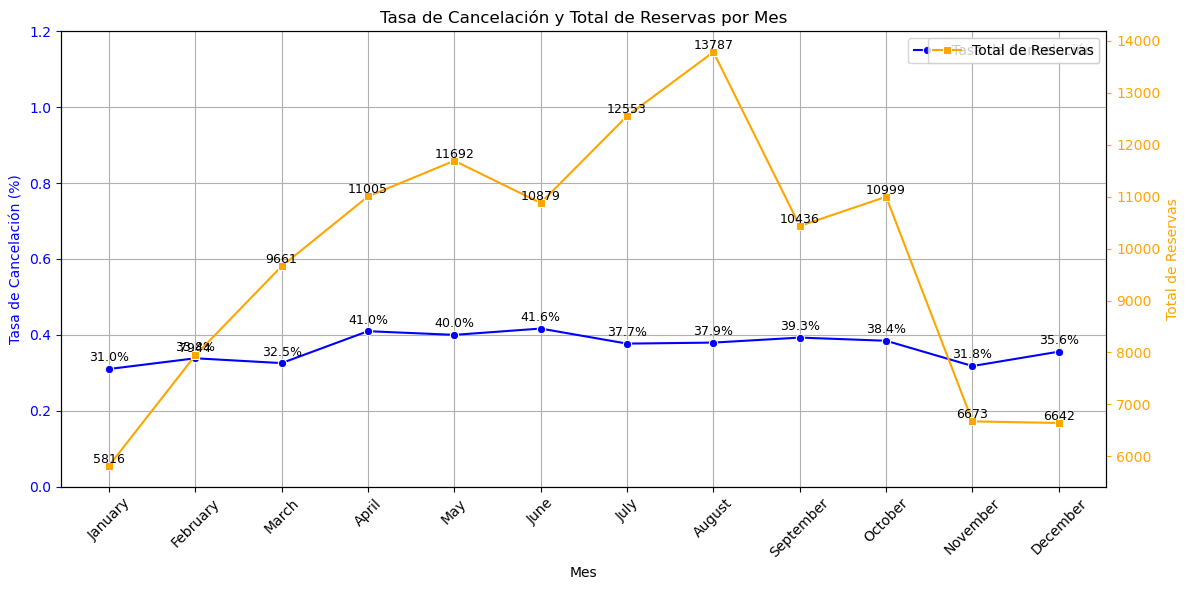

In [9]:
# 2. Asegurar orden correcto de meses y convertir en categoría ordenada
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
df['arrival_date_month'] = pd.Categorical(
    df['arrival_date_month'],
    categories=month_order,
    ordered=True
)

# 3. Cálculo de tasa de cancelación y total de reservas por mes
monthly = (
    df
    .groupby('arrival_date_month', observed=False)  # evita el FutureWarning
    .agg(
        cancellation_rate=('is_canceled', 'mean'),
        total_reservations=('is_canceled', 'size')
    )
    .reset_index()
)

# 4. Gráfico con doble eje Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# 4a. Tasa de cancelación (eje izquierdo)
sns.lineplot(
    ax=ax1,
    data=monthly,
    x='arrival_date_month',
    y='cancellation_rate',
    marker='o',
    color='blue',
    label='Tasa de Cancelación'
)
# Etiquetas de porcentaje
for idx, row in monthly.iterrows():
    ax1.text(
        idx,
        row.cancellation_rate + 0.02,
        f"{row.cancellation_rate*100:.1f}%",
        ha='center',
        fontsize=9,
        color='black'
    )
ax1.set_ylabel('Tasa de Cancelación (%)', color='blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_ylim(0, 1.2)

# 4b. Total de reservas (eje derecho)
ax2 = ax1.twinx()
sns.lineplot(
    ax=ax2,
    data=monthly,
    x='arrival_date_month',
    y='total_reservations',
    marker='s',
    color='orange',
    label='Total de Reservas'
)
# Etiquetas de total de reservas
for idx, row in monthly.iterrows():
    ax2.text(
        idx,
        row.total_reservations,
        f"{row.total_reservations}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
ax2.set_ylabel('Total de Reservas', color='orange')
ax2.tick_params(axis='y', colors='orange')

# 5. Personalización común
ax1.set_xlabel('Mes')
plt.title('Tasa de Cancelación y Total de Reservas por Mes')
ax1.set_xticks(range(len(monthly)))
ax1.set_xticklabels(monthly['arrival_date_month'], rotation=45)
ax1.grid(True)

plt.tight_layout()
plt.show()

/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

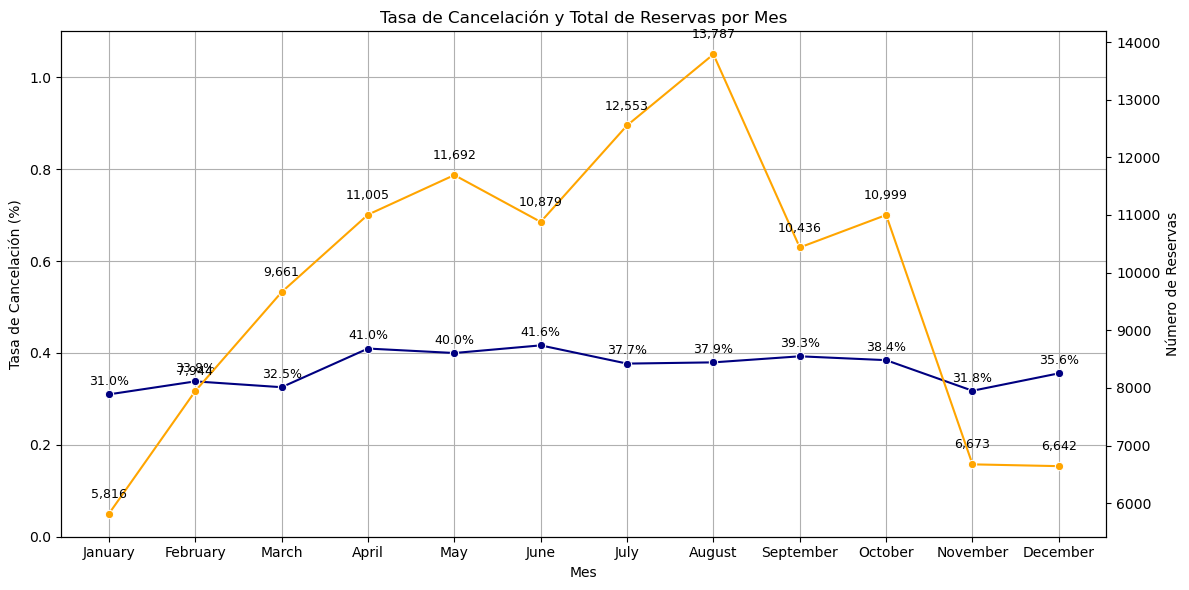

In [10]:
# Asegurar orden cronológico de los meses
month_map = {
    'January': 1, 'February': 2, 'March': 3,
    'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9,
    'October': 10, 'November': 11, 'December': 12
}

monthly_cancellation = monthly_cancellation.reset_index()
monthly_cancellation["month_num"] = monthly_cancellation["arrival_date_month"].map(month_map)
monthly_cancellation = monthly_cancellation.sort_values("month_num")

# Crear figura y eje principal
fig, ax1 = plt.subplots(figsize=(12, 6))

# Línea: tasa de cancelación
sns.lineplot(
    data=monthly_cancellation,
    x="arrival_date_month",
    y="cancellation_rate",
    marker="o",
    color="navy",
    ax=ax1
)
ax1.set_ylabel("Tasa de Cancelación (%)", color="black")
ax1.set_ylim(0, 1.1)
ax1.tick_params(axis='y', labelcolor="black")

# Etiquetas de datos (cancelación)
for i, row in monthly_cancellation.iterrows():
    ax1.text(
        row['arrival_date_month'],
        row['cancellation_rate'] + 0.02,
        f"{row['cancellation_rate'] * 100:.1f}%",
        ha='center',
        fontsize=9,
        color='black'
    )

# Segundo eje: total de reservas
ax2 = ax1.twinx()

# Línea: total de reservas
sns.lineplot(
    data=monthly_cancellation,
    x="arrival_date_month",
    y="total_bookings",
    marker="o",
    color="orange",
    ax=ax2
)
ax2.set_ylabel("Número de Reservas", color="black")
ax2.tick_params(axis='y', labelcolor="black")

# Etiquetas de datos (reservas)
for i, row in monthly_cancellation.iterrows():
    ax2.text(
        row['arrival_date_month'],
        row['total_bookings'] + max(monthly_cancellation['total_bookings']) * 0.02,
        f"{row['total_bookings']:,}",
        ha='center',
        fontsize=9,
        color='black'
    )

# Ajustes finales
plt.title("Tasa de Cancelación y Total de Reservas por Mes")
ax1.set_xlabel("Mes")
plt.xticks(rotation=45)
ax1.grid(True)
plt.tight_layout()
plt.show()

Coeficiente de correlación (reservas vs tasa de cancelación): 0.574


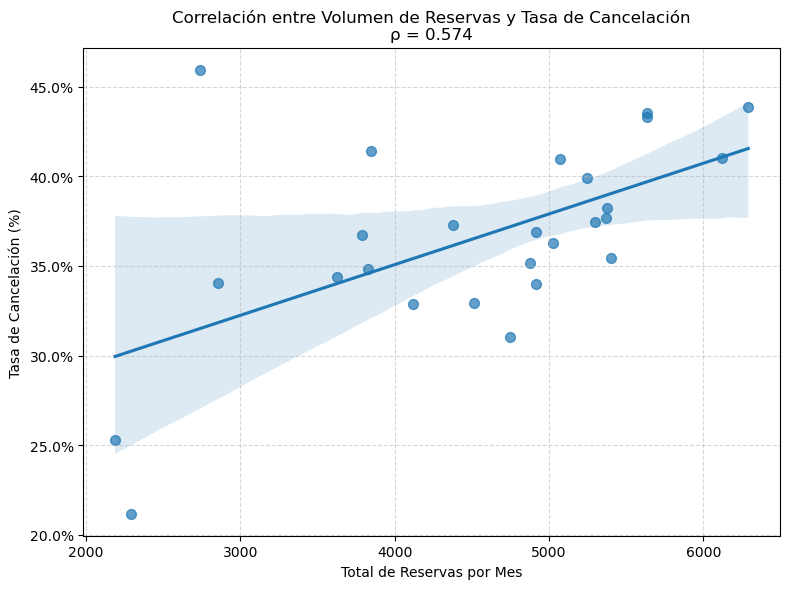

In [11]:
# 1. Carga y asegurarte de que arrival_date esté en datetime
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Agrupar por mes (PeriodIndex) y calcular:
#    - total_reservations: cuenta de filas (reservas)
#    - cancellation_rate: media de is_canceled
monthly = (
    df
    .groupby(df['arrival_date'].dt.to_period('M'), observed=False)
    .agg(
        total_reservations=('is_canceled','size'),
        cancellation_rate=('is_canceled','mean')
    )
    .reset_index()
)
# convertir el Period a timestamp para trazar
monthly['month'] = monthly['arrival_date'].dt.to_timestamp()

# 3. Correlación de Pearson
corr_value = monthly['total_reservations'].corr(monthly['cancellation_rate'])
print(f"Coeficiente de correlación (reservas vs tasa de cancelación): {corr_value:.3f}")

# 4. Scatter + línea de regresión
plt.figure(figsize=(8,6))
sns.regplot(
    data=monthly,
    x='total_reservations',
    y='cancellation_rate',
    marker='o',
    scatter_kws={'s':50, 'alpha':0.7}
)
plt.xlabel('Total de Reservas por Mes')
plt.ylabel('Tasa de Cancelación (%)')
plt.title('Correlación entre Volumen de Reservas y Tasa de Cancelación\n'
          f'ρ = {corr_value:.3f}')
# formatear eje Y en %
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


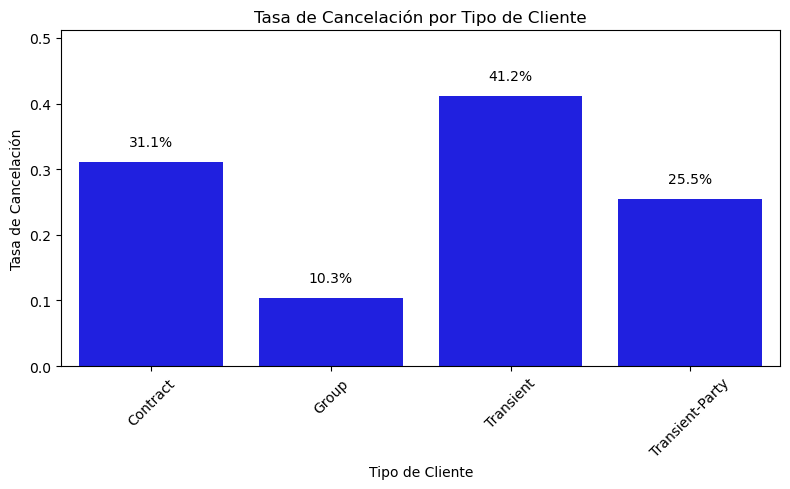

In [12]:
# (Recalcula customer_type_cancellation con observed=False para evitar el FutureWarning:)
customer_type_cancellation = (
    df.groupby('customer_type', observed=False)
      .agg(total_bookings=('is_canceled','count'),
           cancellations=('is_canceled','sum'))
)
customer_type_cancellation['cancellation_rate'] = (
    customer_type_cancellation['cancellations']
    / customer_type_cancellation['total_bookings']
)

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(
    x=customer_type_cancellation.index,
    y='cancellation_rate',
    data=customer_type_cancellation,
    color='blue',
    ax=ax
)
ax.set_title('Tasa de Cancelación por Tipo de Cliente')
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Tasa de Cancelación')
ax.set_ylim(0, customer_type_cancellation['cancellation_rate'].max() + 0.1)
plt.xticks(rotation=45)

# Añadir etiquetas de datos sobre cada barra:
for patch in ax.patches:
    height = patch.get_height()
    x_pos = patch.get_x() + patch.get_width()/2
    ax.text(
        x_pos,
        height + 0.02,
        f"{height*100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()



## 1. Visualización de la relación entre lead_time y la tasa de cancelación

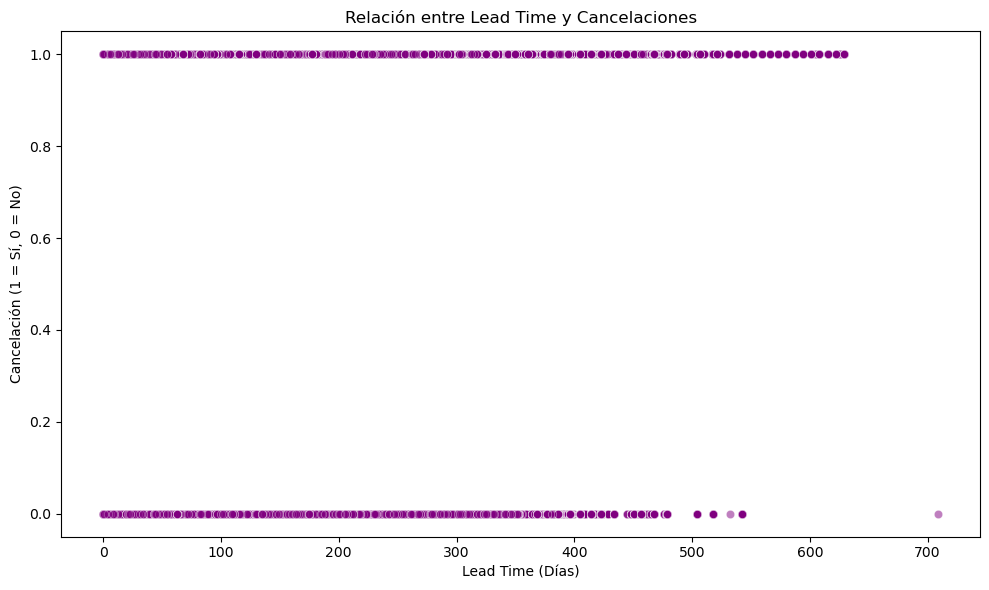

In [13]:
# Visualizar la relación entre 'lead_time' y 'is_canceled'
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='lead_time', 
    y='is_canceled', 
    data=df, 
    color='purple', 
    alpha=0.5
)
plt.title('Relación entre Lead Time y Cancelaciones')
plt.xlabel('Lead Time (Días)')
plt.ylabel('Cancelación (1 = Sí, 0 = No)')
plt.tight_layout()
plt.show()

## 2. Calcular la tasa de cancelación por intervalos de lead_time

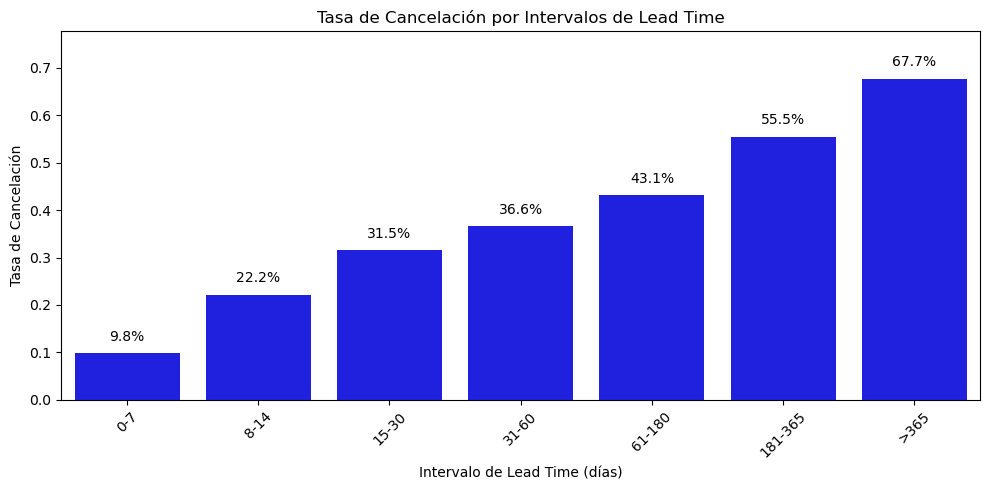

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 1. Definir intervalos de lead_time y etiquetas
bins = [0, 7, 14, 30, 60, 180, 365, df['lead_time'].max()]
labels = ['0-7', '8-14', '15-30', '31-60', '61-180', '181-365', f'>{365}']
df['lead_time_category'] = pd.cut(
    df['lead_time'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# 2. Agrupar por lead_time_category
lead_time_cancellation = (
    df
    .groupby('lead_time_category', observed=False)
    .agg(
        total_bookings=('is_canceled', 'size'),
        cancellations=('is_canceled', 'sum')
    )
    .reset_index()
)
lead_time_cancellation['cancellation_rate'] = (
    lead_time_cancellation['cancellations'] 
    / lead_time_cancellation['total_bookings']
)

# 3. Preparar DataFrame para graficar
plot_df = lead_time_cancellation.copy()
plot_df['lead_time_category'] = plot_df['lead_time_category'].astype(str)

# 4. Barplot con anotaciones
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    data=plot_df,
    x='lead_time_category',
    y='cancellation_rate',
    color='blue',
    ax=ax
)

ax.set_title('Tasa de Cancelación por Intervalos de Lead Time')
ax.set_xlabel('Intervalo de Lead Time (días)')
ax.set_ylabel('Tasa de Cancelación')
ax.set_ylim(0, plot_df['cancellation_rate'].max() + 0.1)
plt.xticks(rotation=45)

# 5. Etiquetas de porcentaje
for patch in ax.patches:
    h = patch.get_height()
    x = patch.get_x() + patch.get_width()/2
    ax.text(
        x, h + 0.02,
        f"{h*100:.1f}%",
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

## relacion entre lead time y tipp de deposito

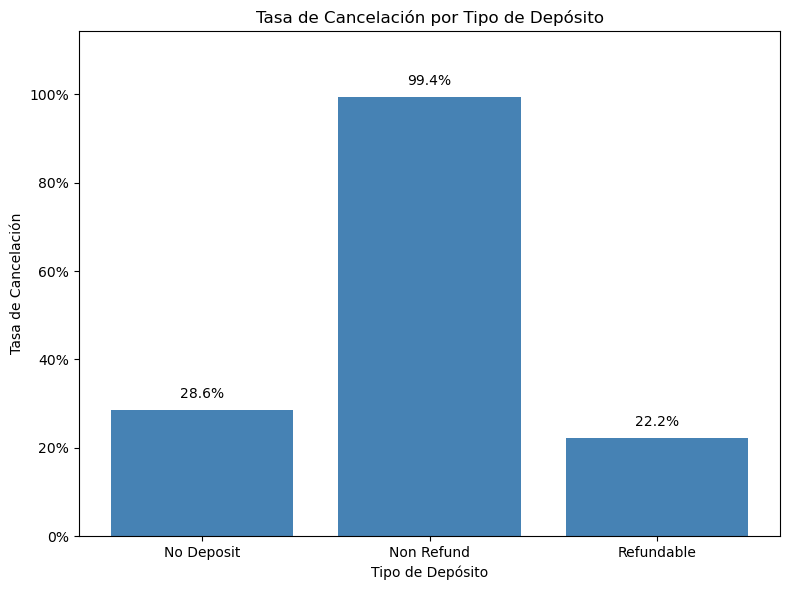

In [30]:
# 2. Agrupar por tipo de depósito y calcular tasa de cancelación
deposit = (
    df
    .groupby('deposit_type', observed=False)
    .agg(
        total=('is_canceled', 'size'),
        canceled=('is_canceled', 'sum')
    )
    .reset_index()
)
deposit['cancel_rate'] = deposit['canceled'] / deposit['total']

# 3. Dibujar el barplot con Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(
    deposit['deposit_type'],
    deposit['cancel_rate'],
    color='steelblue'
)

# 4. Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylim(0, deposit['cancel_rate'].max() * 1.15)

# 5. Anotar porcentajes encima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + 0.02,
        f"{h * 100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# 6. Etiquetas y título
ax.set_xlabel('Tipo de Depósito')
ax.set_ylabel('Tasa de Cancelación')
ax.set_title('Tasa de Cancelación por Tipo de Depósito')

plt.tight_layout()
plt.show()

In [31]:
# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Total de registros por tipo de depósito
total_by_deposit = (
    df['deposit_type']
      .value_counts()
      .reset_index()
      .rename(columns={'index':'deposit_type', 'deposit_type':'total_records'})
)
print("Total de registros por tipo de depósito:")
display(total_by_deposit)

# 3. Filtrar solo "Non Refund"
non_refund = df[df['deposit_type'] == 'Non Refund']

# 4. Agrupar por reservation_status para Non Refund, obteniendo conteo y proporción
status_summary = (
    non_refund
      .groupby('reservation_status', observed=False)
      .agg(count=('reservation_status','size'))
      .reset_index()
)
# añadir proporción
status_summary['proportion'] = status_summary['count'] / status_summary['count'].sum()

print("\nConteo y proporción de reservation_status en 'Non Refund':")
display(status_summary)


Total de registros por tipo de depósito:


,total_records,count
0,No Deposit,103353
1,Non Refund,14572
2,Refundable,162



Conteo y proporción de reservation_status en 'Non Refund':


,reservation_status,count,proportion
0,Canceled,14445,0.991285
1,Check-Out,93,0.006382
2,No-Show,34,0.002333


/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


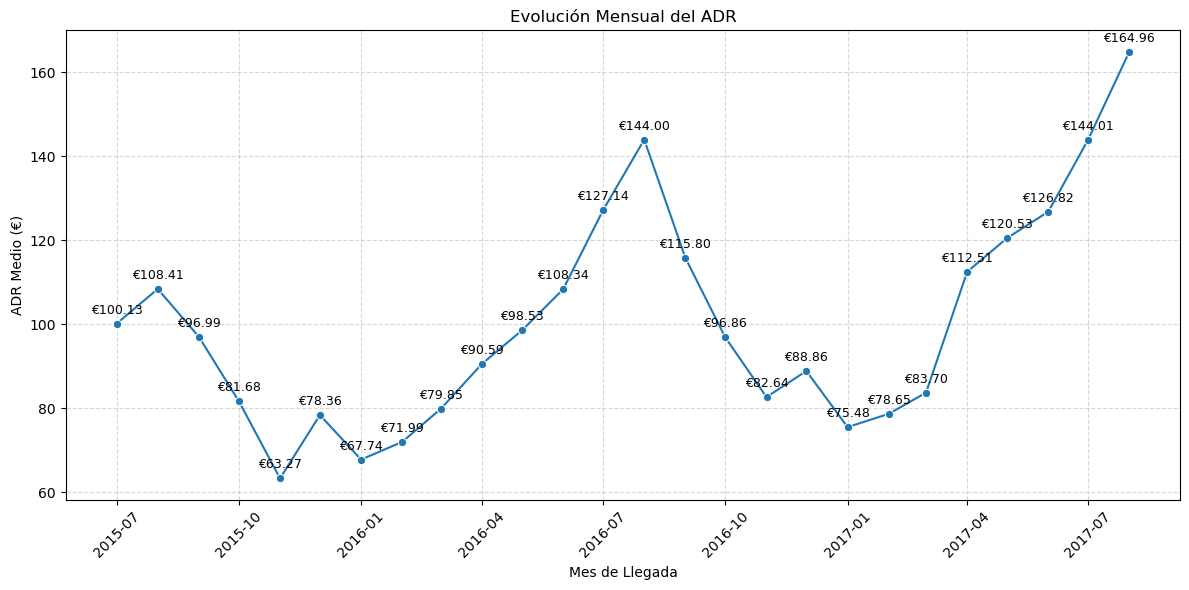

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Asegúrate de que arrival_date y adr_monthly ya estén calculados como antes…

# … tras calcular adr_monthly …
# Convertir infinitos a NaN y eliminar esas filas
adr_monthly['adr_mean'] = adr_monthly['adr_mean'].replace([np.inf, -np.inf], np.nan)
adr_monthly = adr_monthly.dropna(subset=['adr_mean'])

# 2) Dibujar el lineplot sin IC y sin futuros warnings
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    data=adr_monthly,
    x='month',
    y='adr_mean',
    marker='o',
    errorbar=None,      # <-- en lugar de ci=None
    ax=ax
)

# 3) Etiquetas encima de cada punto
offset = adr_monthly['adr_mean'].max() * 0.01
for x, y in zip(adr_monthly['month'], adr_monthly['adr_mean']):
    ax.text(
        x,
        y + offset,
        f"€{y:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# 4) Estilo y presentación
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución Mensual del ADR')
plt.xticks(rotation=45)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


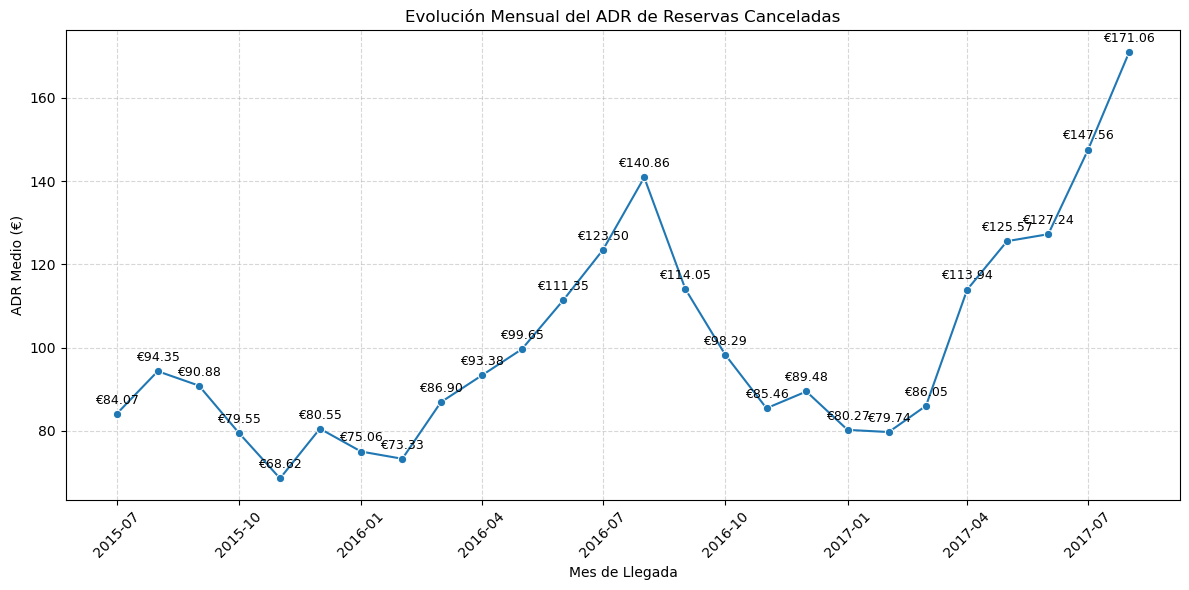

In [41]:
# 5. Graficar la evolución mensual del ADR para canceladas con etiquetas de datos
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    data=adr_cancel_trend,
    x='month',
    y='adr_mean',
    marker='o',
    errorbar=None,   # desactiva IC para evitar warnings
    ax=ax
)

# Offset para separar la etiqueta del punto
offset = adr_cancel_trend['adr_mean'].max() * 0.01

# Añadir etiqueta encima de cada punto
for x, y in zip(adr_cancel_trend['month'], adr_cancel_trend['adr_mean']):
    ax.text(
        x,
        y + offset,
        f"€{y:.2f}",    # formato de moneda
        ha='center',
        va='bottom',
        fontsize=9
    )

# Resto de estilo
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución Mensual del ADR de Reservas Canceladas')
plt.xticks(rotation=45)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reboot-student/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

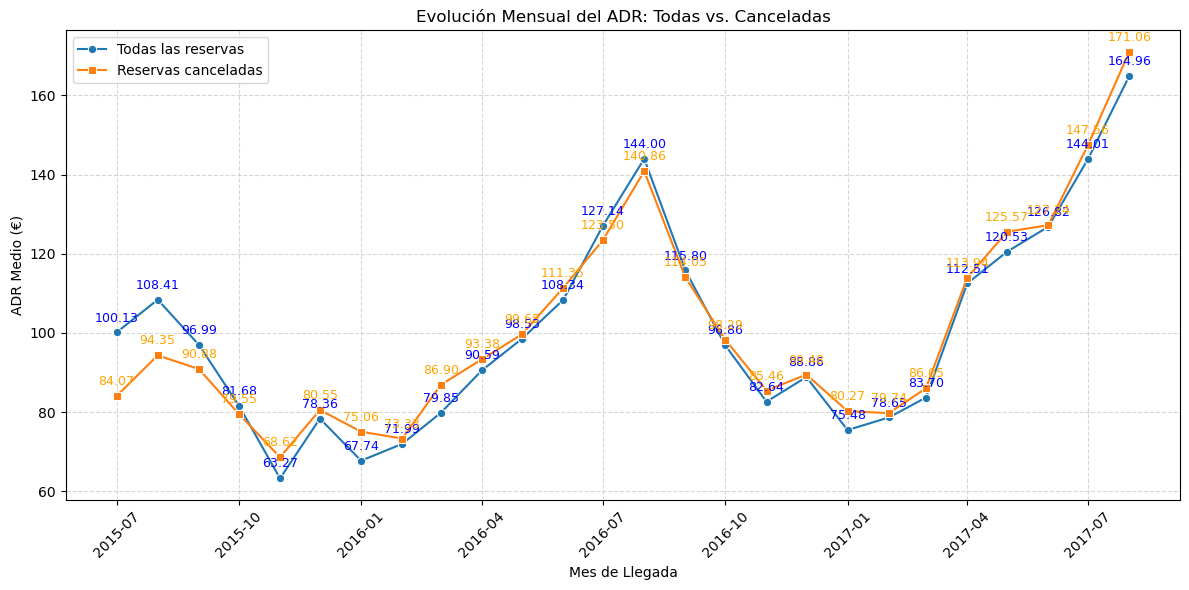

In [19]:
# 2. Cálculo de ADR mensual para todas las reservas
adr_all = (
    df
    .groupby(df['arrival_date'].dt.to_period('M'), observed=False)
    .agg(adr_mean=('adr', 'mean'))
    .reset_index()
)
adr_all['month'] = adr_all['arrival_date'].dt.to_timestamp()

# 3. Cálculo de ADR mensual solo para reservas canceladas
canceled = df[df['is_canceled'] == 1]
adr_cancel = (
    canceled
    .groupby(canceled['arrival_date'].dt.to_period('M'), observed=False)
    .agg(adr_mean=('adr', 'mean'))
    .reset_index()
)
adr_cancel['month'] = adr_cancel['arrival_date'].dt.to_timestamp()

# 4. Graficar ambas series
fig, ax = plt.subplots(figsize=(12, 6))

# Línea de ADR para todas las reservas
sns.lineplot(
    ax=ax,
    data=adr_all,
    x='month',
    y='adr_mean',
    marker='o',
    label='Todas las reservas'
)
# Anotar cada punto
for x, y in zip(adr_all['month'], adr_all['adr_mean']):
    ax.text(
        x, y + 2,               # ajusta "+ 2" según tu escala de ADR
        f"{y:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='blue'
    )

# Línea de ADR para reservas canceladas
sns.lineplot(
    ax=ax,
    data=adr_cancel,
    x='month',
    y='adr_mean',
    marker='s',
    label='Reservas canceladas'
)
# Anotar cada punto
for x, y in zip(adr_cancel['month'], adr_cancel['adr_mean']):
    ax.text(
        x, y + 2,
        f"{y:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='orange'
    )

# 5. Estilo y etiquetas
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución Mensual del ADR: Todas vs. Canceladas')
ax.legend(title='')
ax.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## grafico de lineas donde se muestre la evolucion del adr en funcion del customer_type

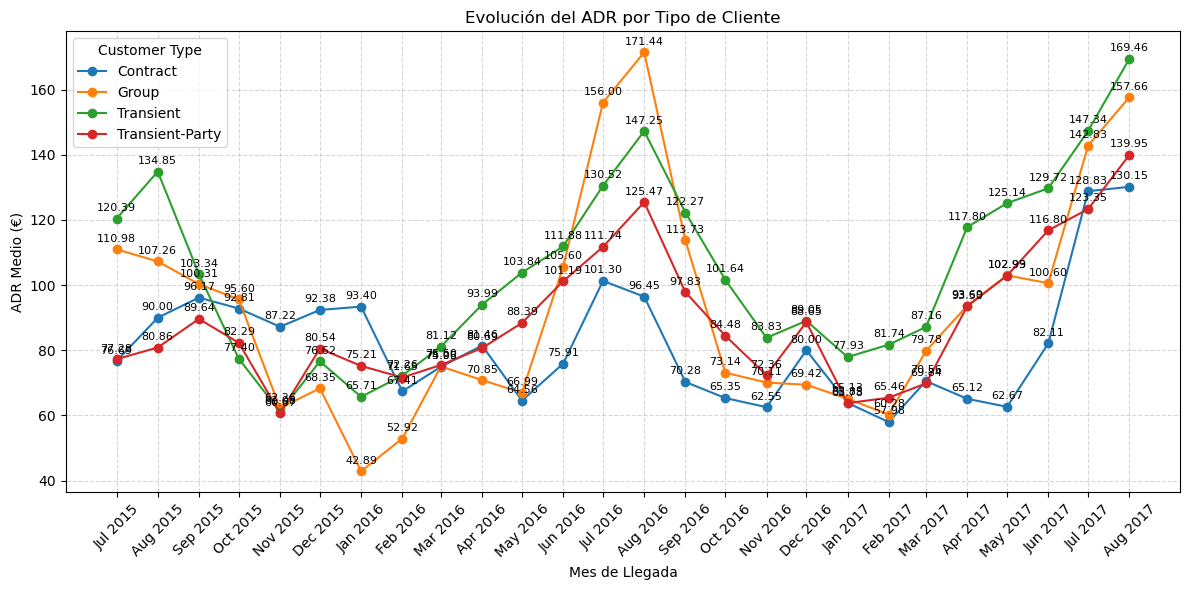

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga y conversión de fecha
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Agrupar por mes y customer_type y calcular ADR medio
grouped = (
    df
    .groupby([df['arrival_date'].dt.to_period('M'), 'customer_type'], observed=False)
    .agg(adr_mean=('adr', 'mean'))
    .reset_index()
)
grouped['month'] = grouped['arrival_date'].dt.to_timestamp()

# 3. Pivot para facilitar el plot
pivot_df = grouped.pivot(index='month', columns='customer_type', values='adr_mean')

# 4. Gráfico de líneas con anotaciones
fig, ax = plt.subplots(figsize=(12, 6))
for ctype in pivot_df.columns:
    ax.plot(
        pivot_df.index, 
        pivot_df[ctype], 
        marker='o', 
        label=ctype
    )
    for x, y in zip(pivot_df.index, pivot_df[ctype]):
        ax.text(
            x, y + pivot_df.values.max() * 0.01,
            f"{y:.2f}",
            ha='center', va='bottom', fontsize=8
        )

# 5. Estilo y etiquetas
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución del ADR por Tipo de Cliente')
ax.set_xticks(pivot_df.index)
ax.set_xticklabels([d.strftime('%b %Y') for d in pivot_df.index], rotation=45)
ax.legend(title='Customer Type')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Evolucion del adr en funcion del customer_type (reservas canceladas)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


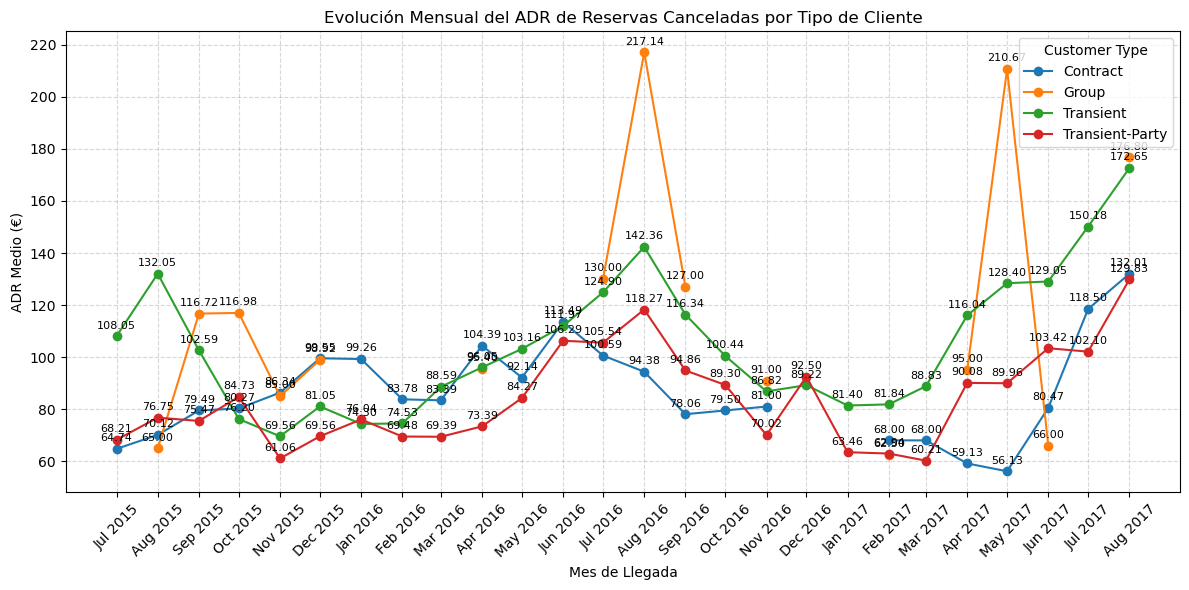

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga y conversión de fecha
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Filtrar solo las reservas canceladas
cancelled = df[df['is_canceled'] == 1].copy()

# 3. Agrupar por mes y customer_type, calcular ADR medio
grouped_cancel = (
    cancelled
    .groupby([cancelled['arrival_date'].dt.to_period('M'), 'customer_type'], observed=False)
    .agg(adr_mean=('adr', 'mean'))
    .reset_index()
)
# Convertir el periodo a timestamp para el eje X
grouped_cancel['month'] = grouped_cancel['arrival_date'].dt.to_timestamp()

# 4. Pivot para tener una columna por tipo de cliente
pivot_cancel = grouped_cancel.pivot(
    index='month', 
    columns='customer_type', 
    values='adr_mean'
)

# 5. Graficar líneas con anotaciones
fig, ax = plt.subplots(figsize=(12, 6))
max_adr = pivot_cancel.max().max()

for ctype in pivot_cancel.columns:
    ax.plot(
        pivot_cancel.index,
        pivot_cancel[ctype],
        marker='o',
        label=ctype
    )
    # Anotar cada punto
    for x, y in zip(pivot_cancel.index, pivot_cancel[ctype]):
        ax.text(
            x,
            y + max_adr * 0.01,
            f"{y:.2f}",
            ha='center',
            va='bottom',
            fontsize=8
        )

# 6. Estilo y etiquetas
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución Mensual del ADR de Reservas Canceladas por Tipo de Cliente')
ax.set_xticks(pivot_cancel.index)
ax.set_xticklabels([d.strftime('%b %Y') for d in pivot_cancel.index], rotation=45)
ax.legend(title='Customer Type')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


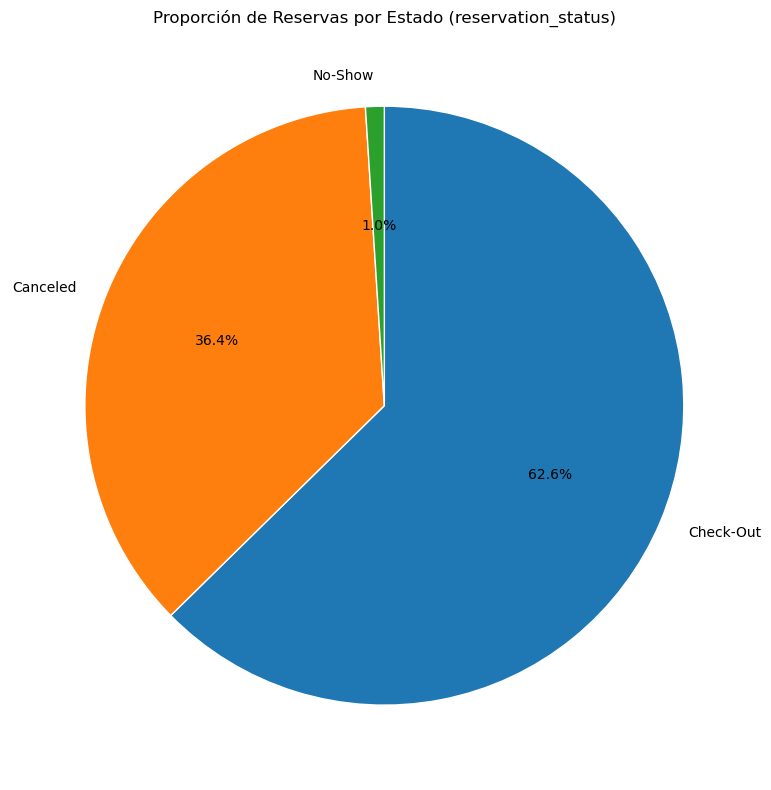

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Conteo de reservation_status
status_counts = df['reservation_status'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Estado (reservation_status)')
plt.tight_layout()
plt.show()


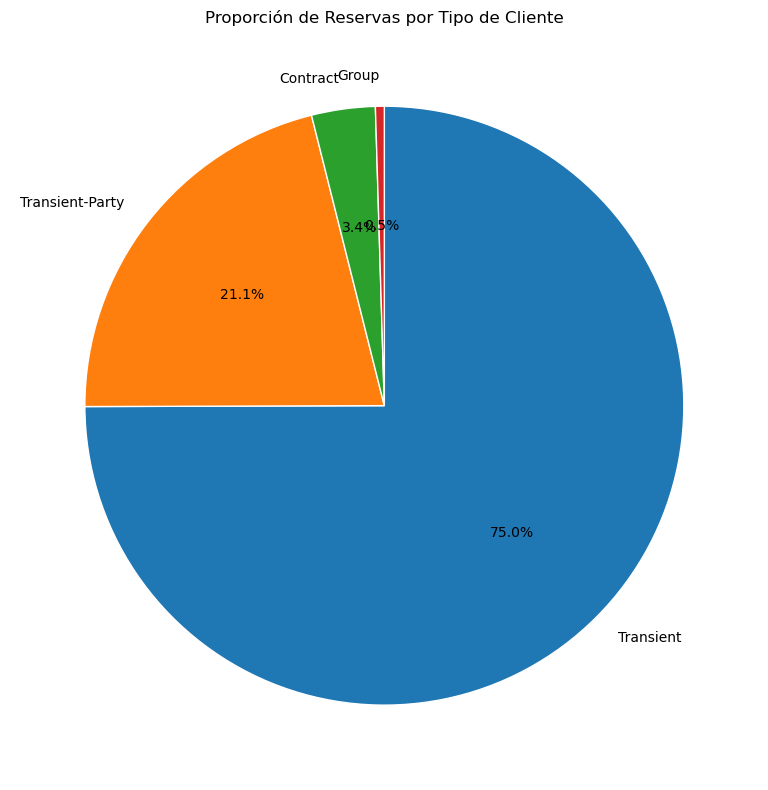

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Conteo de customer_type
type_counts = df['customer_type'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    type_counts,
    labels=type_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Tipo de Cliente')
plt.tight_layout()
plt.show()


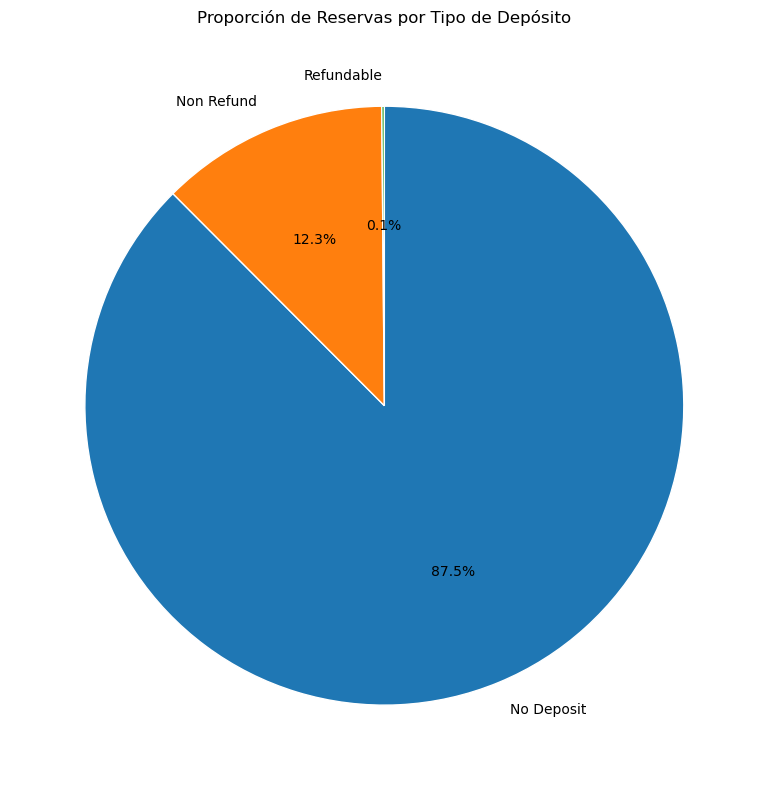

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Conteo de deposit_type
deposit_counts = df['deposit_type'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    deposit_counts,
    labels=deposit_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Tipo de Depósito')
plt.tight_layout()
plt.show()


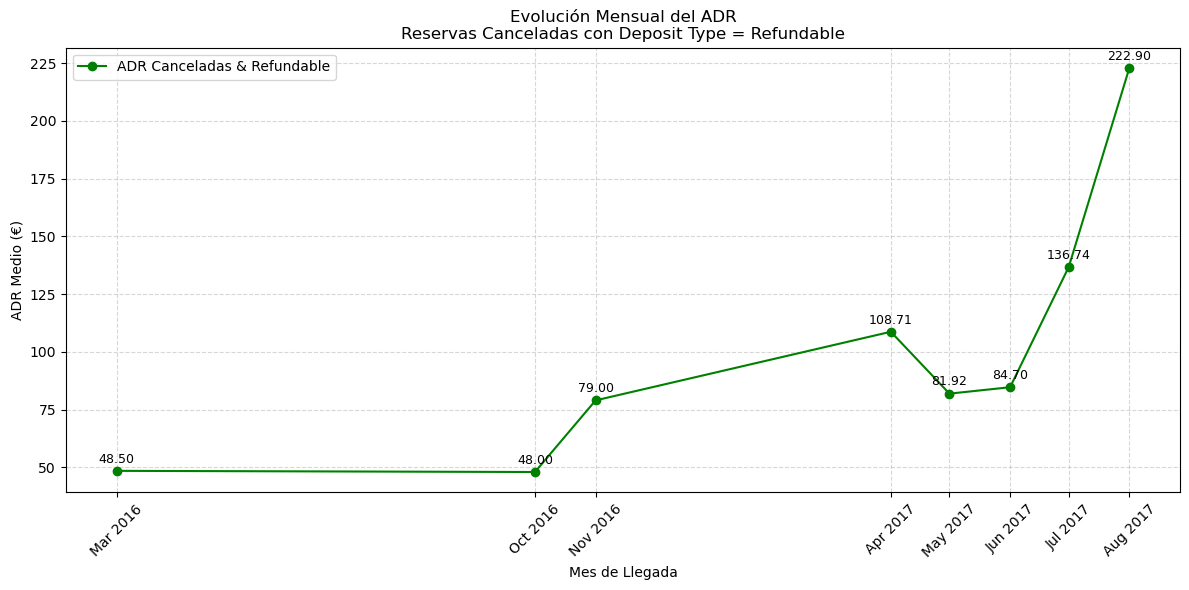

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga y conversión a datetime
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Filtrar solo las reservas canceladas con deposit_type "Refundable"
mask = (df['is_canceled'] == 1) & (df['deposit_type'] == 'Refundable')
df_refund_cancel = df[mask].copy()

# 3. Agrupar por mes y calcular ADR medio
adr_refund_cancel = (
    df_refund_cancel
      .groupby(df_refund_cancel['arrival_date'].dt.to_period('M'), observed=False)
      .agg(adr_mean=('adr', 'mean'))
      .reset_index()
)
adr_refund_cancel['month'] = adr_refund_cancel['arrival_date'].dt.to_timestamp()

# 4. Graficar la evolución del ADR
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    adr_refund_cancel['month'],
    adr_refund_cancel['adr_mean'],
    marker='o',
    color='green',
    label='ADR Canceladas & Refundable'
)

# 5. Añadir etiquetas de datos encima de cada punto
max_adr = adr_refund_cancel['adr_mean'].max()
for x, y in zip(adr_refund_cancel['month'], adr_refund_cancel['adr_mean']):
    ax.text(
        x, y + max_adr * 0.01,
        f"{y:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# 6. Estilo y etiquetas
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución Mensual del ADR\nReservas Canceladas con Deposit Type = Refundable')
ax.set_xticks(adr_refund_cancel['month'])
ax.set_xticklabels([d.strftime('%b %Y') for d in adr_refund_cancel['month']], rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


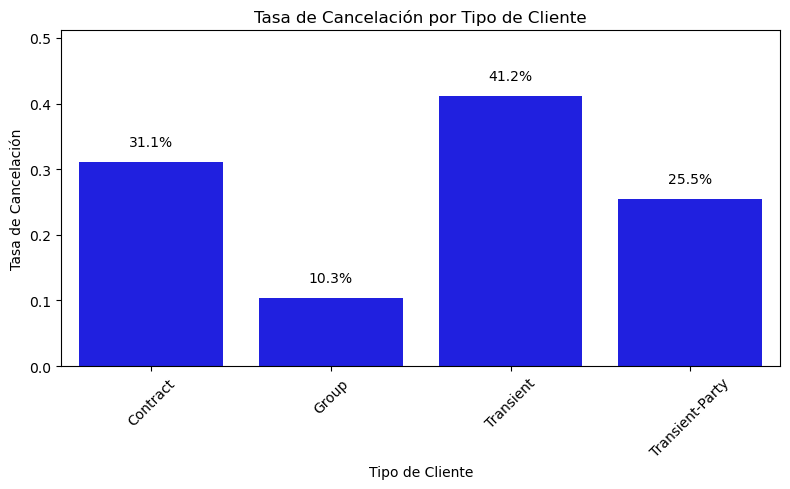

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(
    x=customer_type_cancellation.index,
    y='cancellation_rate',
    data=customer_type_cancellation,
    color='blue',
    ax=ax
)
ax.set_title('Tasa de Cancelación por Tipo de Cliente')
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Tasa de Cancelación')
ax.set_ylim(0, customer_type_cancellation['cancellation_rate'].max() + 0.1)
plt.xticks(rotation=45)

# Ahora i es la posición (0,1,2,3) y cat la categoría
for i, cat in enumerate(customer_type_cancellation.index):
    rate = customer_type_cancellation.loc[cat, 'cancellation_rate']
    ax.text(
        i,
        rate + 0.02,
        f"{rate*100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


## Análisis bivariante: cancelación vs. otras variables

Variables categóricas

    Segmento de cliente (market_segment), tipo de hotel (hotel), tipo de cliente (customer_type), depósito (deposit_type).

    Cruza cada variable con is_canceled y calcula tasas; visualiza con barras apiladas o mosaicos.

    Test de chi-cuadrado en cada cruce.

Variables numéricas

    lead_time, adr (tarifa diaria), stays_in_weekend_nights, etc.

    Boxplots de cada variable separados por canceled=True/False.

    Correlación de punto biserial o U de Mann–Whitney para ver si los distribuciones difieren.

### Variables categóricas


=== Variable: market_segment ===



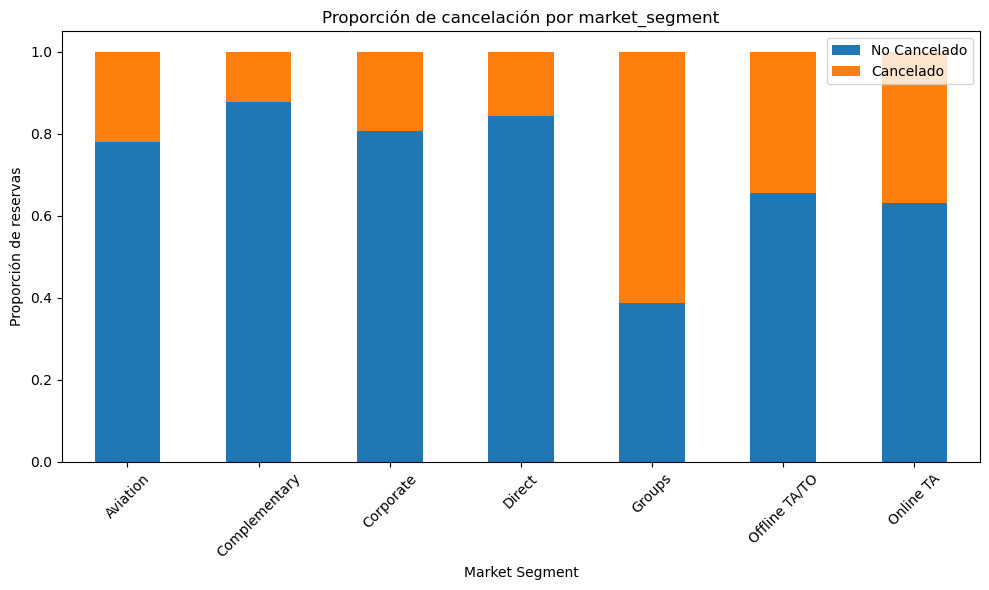

<Figure size 800x500 with 0 Axes>

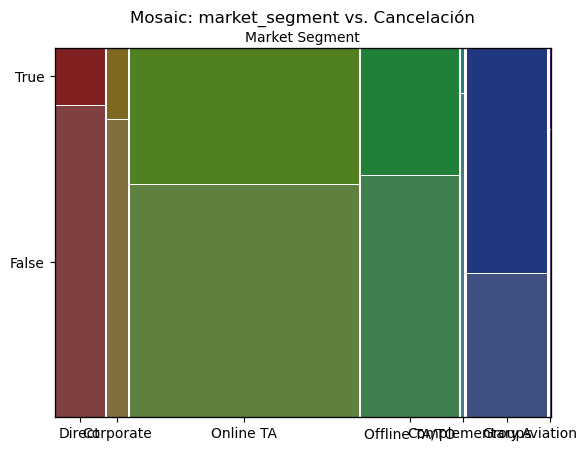

Chi² = 8302.35,  p-valor = 0.0000
→ Hay evidencia de asociación significativa.


=== Variable: hotel ===



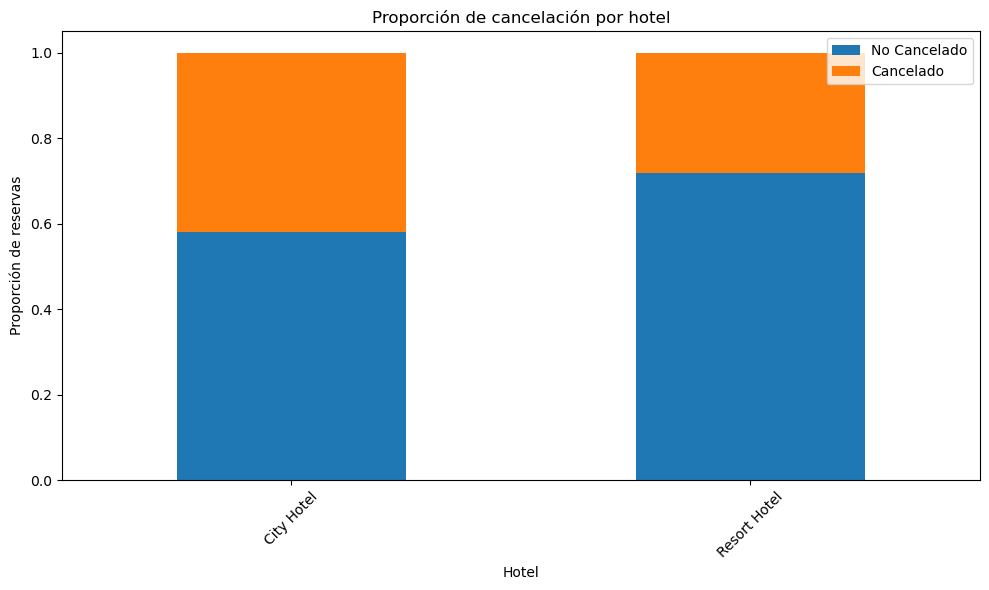

<Figure size 800x500 with 0 Axes>

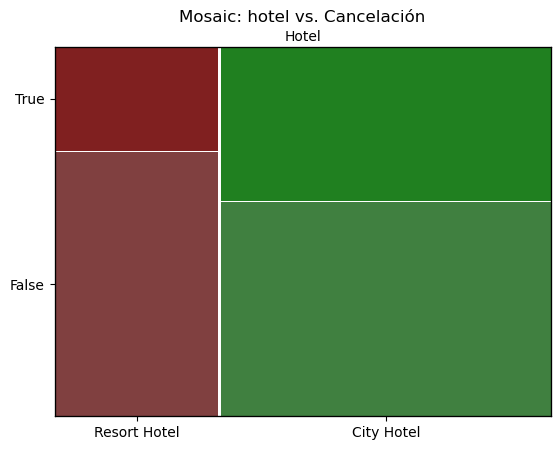

Chi² = 2091.00,  p-valor = 0.0000
→ Hay evidencia de asociación significativa.


=== Variable: customer_type ===



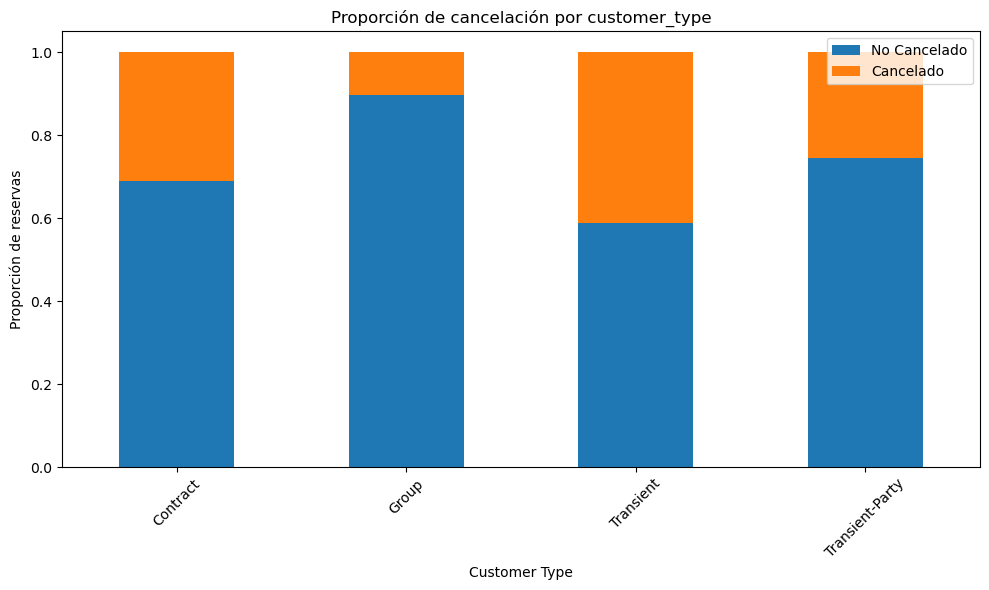

<Figure size 800x500 with 0 Axes>

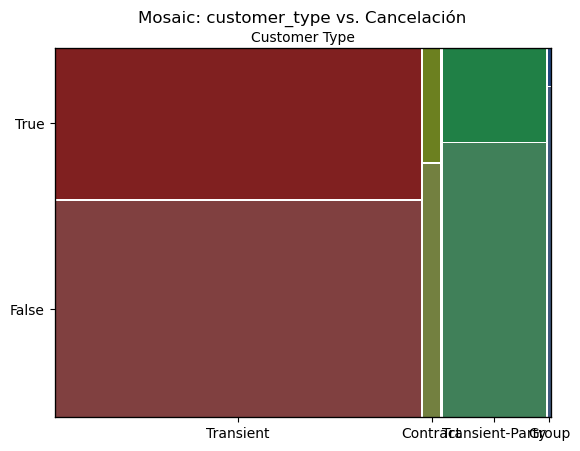

Chi² = 2286.54,  p-valor = 0.0000
→ Hay evidencia de asociación significativa.


=== Variable: deposit_type ===



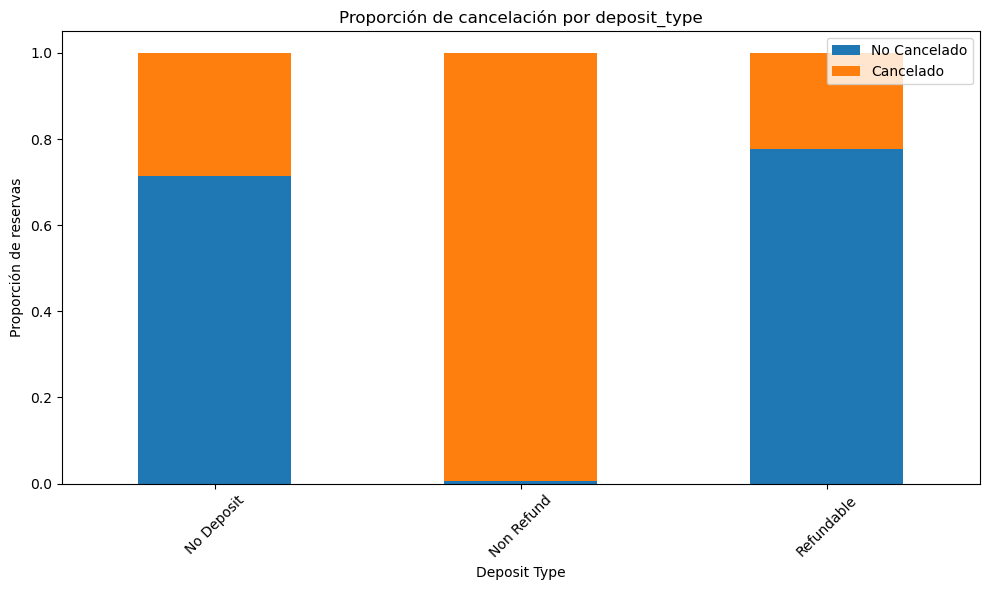

<Figure size 800x500 with 0 Axes>

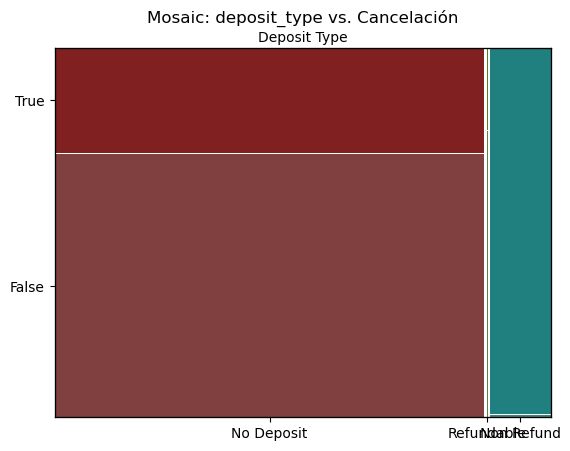

Chi² = 27312.75,  p-valor = 0.0000
→ Hay evidencia de asociación significativa.



In [50]:
# 4.1 Análisis bivariante: cancelación vs. variables categóricas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

# Asume que ya tienes el df preparado con la columna 'is_canceled'
# y las variables categóricas: market_segment, hotel, customer_type, deposit_type.

categorical_vars = ['market_segment', 'hotel', 'customer_type', 'deposit_type']

for var in categorical_vars:
    print(f"\n=== Variable: {var} ===\n")
    
    # 1) Tabla de contingencia
    ct = pd.crosstab(df[var], df['is_canceled'])
    ct.columns = ['No Cancelado', 'Cancelado']
    
    # 2) Proporciones por categoría
    ct_prop = ct.div(ct.sum(axis=1), axis=0)
    
    # 3) Gráfico de barras apiladas (proporciones)
    plt.figure(figsize=(10, 6))
    ct_prop.plot(
        kind='bar', 
        stacked=True, 
        ax=plt.gca()
    )
    plt.title(f'Proporción de cancelación por {var}')
    plt.ylabel('Proporción de reservas')
    plt.xlabel(var.replace('_', ' ').title())
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4) Mosaic plot (opcional, para ver la independencia)
    plt.figure(figsize=(8, 5))
    mosaic(
        df, 
        [var, 'is_canceled'], 
        title=f'Mosaic: {var} vs. Cancelación',
        labelizer=lambda k: ''  # oculta las etiquetas internas para claridad
    )
    plt.xlabel(var.replace('_', ' ').title())
    plt.ylabel('Cancelación (0=No, 1=Sí)')
    plt.show()
    
    # 5) Test de chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"Chi² = {chi2:.2f},  p-valor = {p:.4f}")
    if p < 0.05:
        print("→ Hay evidencia de asociación significativa.\n")
    else:
        print("→ No hay evidencia de asociación significativa.\n")



=== Variable: market_segment ===



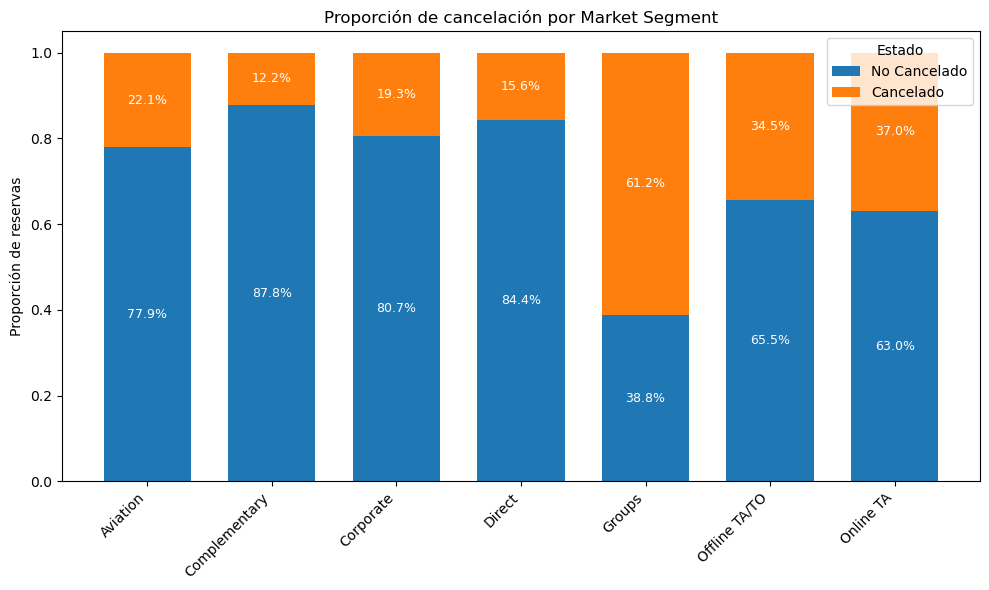

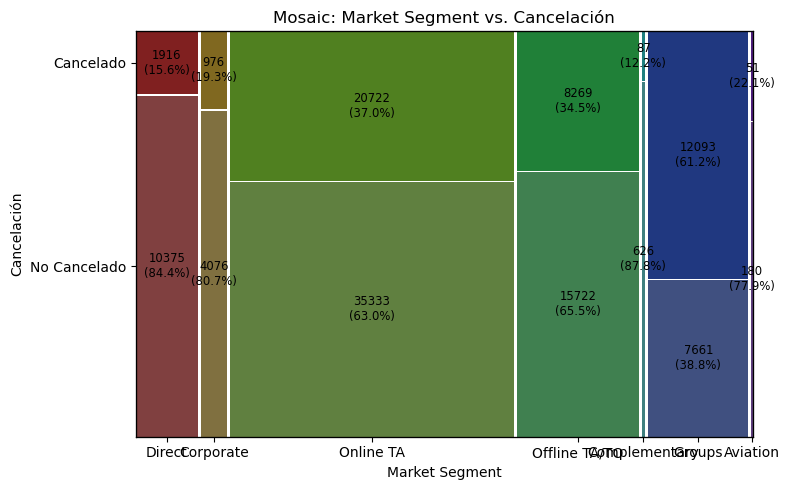

Chi² = 8302.35, p-valor = 0.0000 → Significativo


=== Variable: hotel ===



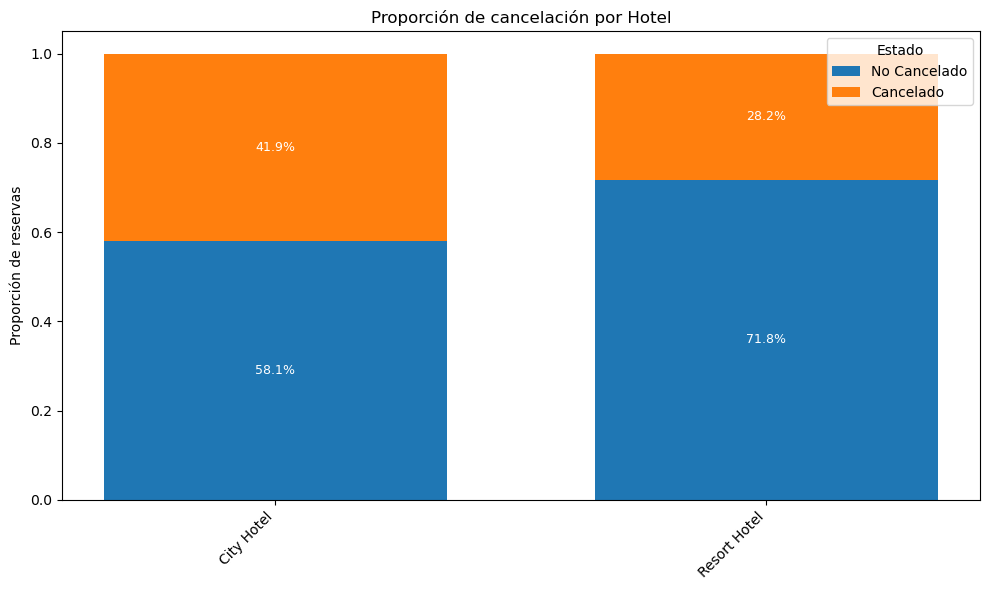

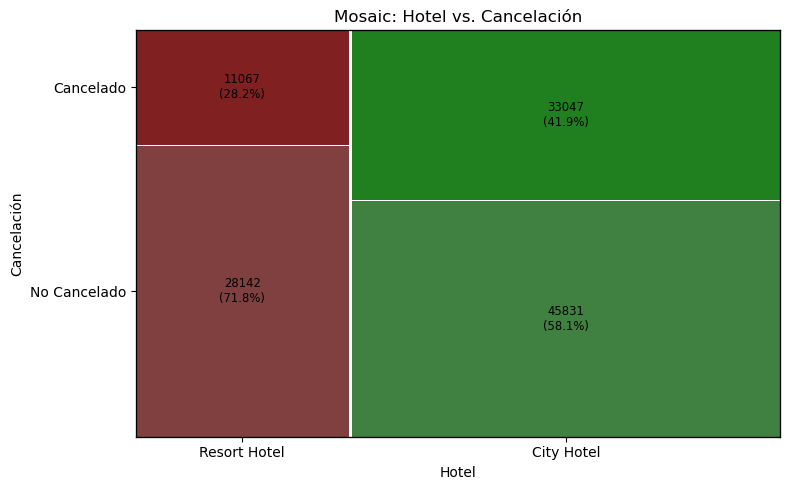

Chi² = 2091.00, p-valor = 0.0000 → Significativo


=== Variable: customer_type ===



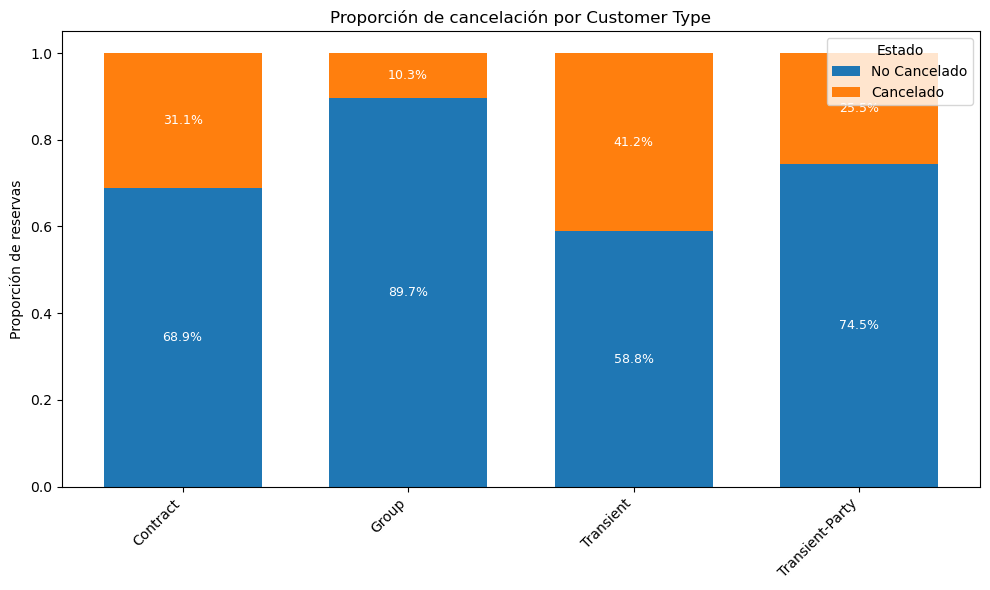

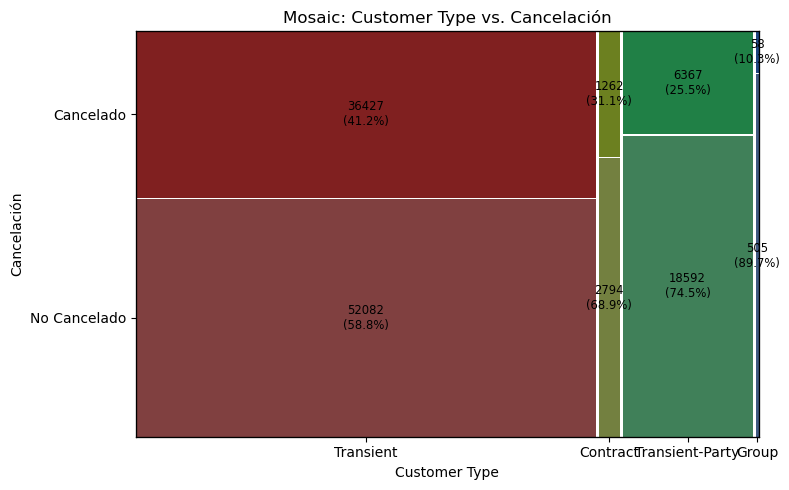

Chi² = 2286.54, p-valor = 0.0000 → Significativo


=== Variable: deposit_type ===



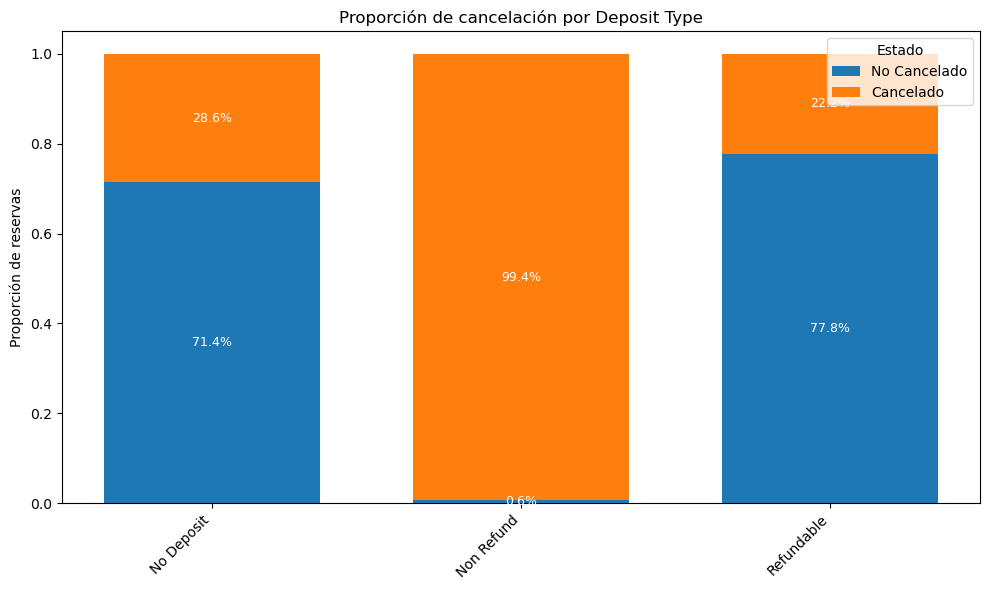

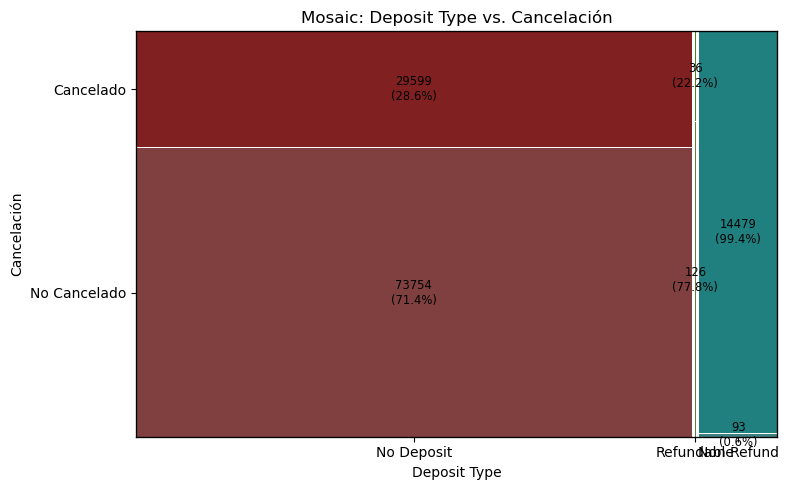

Chi² = 27312.75, p-valor = 0.0000 → Significativo



In [71]:
# 4.1 Análisis bivariante: cancelación vs. variables categóricas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

# 0) Carga del CSV y mapeo de la columna de cancelación a texto

df['cancel_label'] = df['is_canceled'].map({False: 'No Cancelado', True: 'Cancelado'})

categorical_vars = ['market_segment', 'hotel', 'customer_type', 'deposit_type']

for var in categorical_vars:
    print(f"\n=== Variable: {var} ===\n")
    
    # 1) Crosstab usando la etiqueta de texto
    ct = pd.crosstab(df[var], df['cancel_label'])
    
    # 2) Proporciones por fila
    ct_prop = ct.div(ct.sum(axis=1), axis=0)
    
    # 3) Gráfico de barras apiladas manual con etiquetas de porcentaje
    labels    = ct_prop.index.tolist()
    no_cancel = ct_prop['No Cancelado'].values
    cancel    = ct_prop['Cancelado'].values
    x         = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, no_cancel, width=0.7, label='No Cancelado')
    ax.bar(x, cancel,    width=0.7, bottom=no_cancel, label='Cancelado')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Proporción de reservas')
    ax.set_title(f'Proporción de cancelación por {var.replace("_", " ").title()}')
    ax.legend(title='Estado', loc='upper right')
    
    # Añadir etiqueta de porcentaje en cada segmento
    for i in range(len(x)):
        if no_cancel[i] > 0:
            ax.text(x[i], no_cancel[i] / 2,
                    f"{no_cancel[i]:.1%}",
                    ha='center', va='center', fontsize=9, color='white')
        if cancel[i] > 0:
            ax.text(x[i], no_cancel[i] + cancel[i] / 2,
                    f"{cancel[i]:.1%}",
                    ha='center', va='center', fontsize=9, color='white')
    plt.tight_layout()
    plt.show()
    
    # 4) Mosaic plot con conteo y porcentaje
    def labelizer(key):
        cat_val, estado = key
        cnt = ct.loc[cat_val, estado]
        pct = ct_prop.loc[cat_val, estado]
        return f"{cnt}\n({pct:.1%})"
    
    fig, ax = plt.subplots(figsize=(8, 5))
    mosaic(df, [var, 'cancel_label'], labelizer=labelizer, ax=ax)
    ax.set_title(f'Mosaic: {var.replace("_", " ").title()} vs. Cancelación')
    ax.set_xlabel(var.replace("_", " ").title())
    ax.set_ylabel('Cancelación')
    plt.tight_layout()
    plt.show()
    
    # 5) Test de chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"Chi² = {chi2:.2f}, p-valor = {p:.4f} → "
          + ("Significativo" if p < 0.05 else "No significativo") + "\n")


In [73]:
# %% [markdown]
# ## 1. Imports y carga de datos

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ajustes opcionales de estilo
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 10

# %%

# Aseguramos datetime
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# Creamos duración total de estancia si no existiera
if 'total_length_of_stay' not in df.columns:
    df['total_length_of_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']


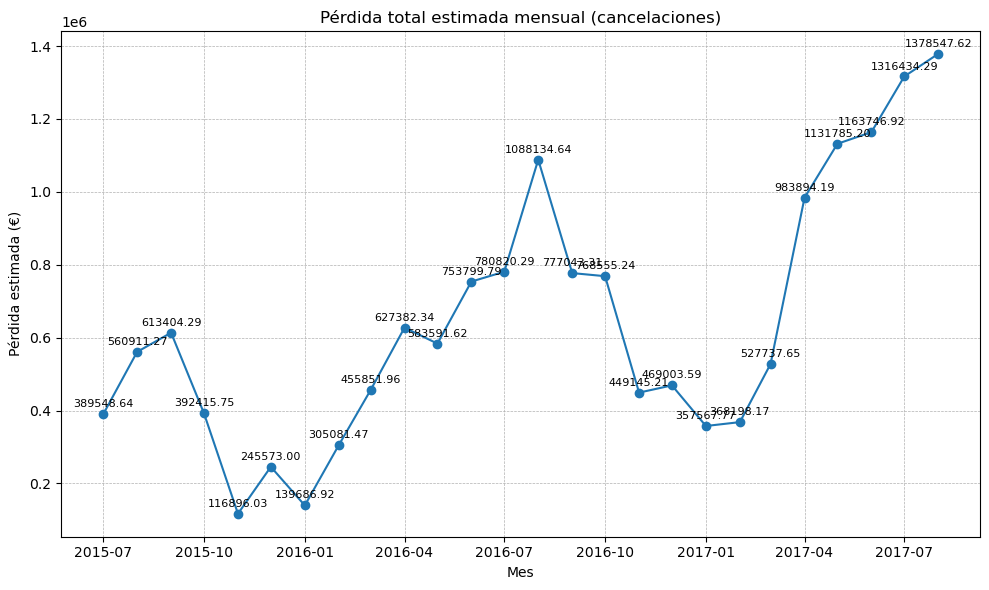

In [74]:
# %% [markdown]
# ## 2. Pérdida total mensual por cancelaciones

# %%
# Filtramos canceladas y calculamos pérdida por reserva
df_canc = df[df['is_canceled'] == True].copy()
df_canc['loss'] = df_canc['adr'] * df_canc['total_length_of_stay']

# Agrupamos y sumamos por mes-año
monthly_loss = (
    df_canc
    .groupby(df_canc['arrival_date'].dt.to_period('M'))['loss']
    .sum()
    .to_timestamp()
)

# %%
# Gráfico de línea
fig, ax = plt.subplots()
ax.plot(monthly_loss.index, monthly_loss.values, marker='o')
ax.set_title('Pérdida total estimada mensual (cancelaciones)')
ax.set_xlabel('Mes')
ax.set_ylabel('Pérdida estimada (€)')
ax.grid(True, linestyle='--', linewidth=0.5)

# Anotamos cada punto
for x, y in zip(monthly_loss.index, monthly_loss.values):
    ax.annotate(f"{y:.2f}", (x, y),
                textcoords="offset points", xytext=(0,5),
                ha='center', fontsize=8)
plt.tight_layout()
plt.show()

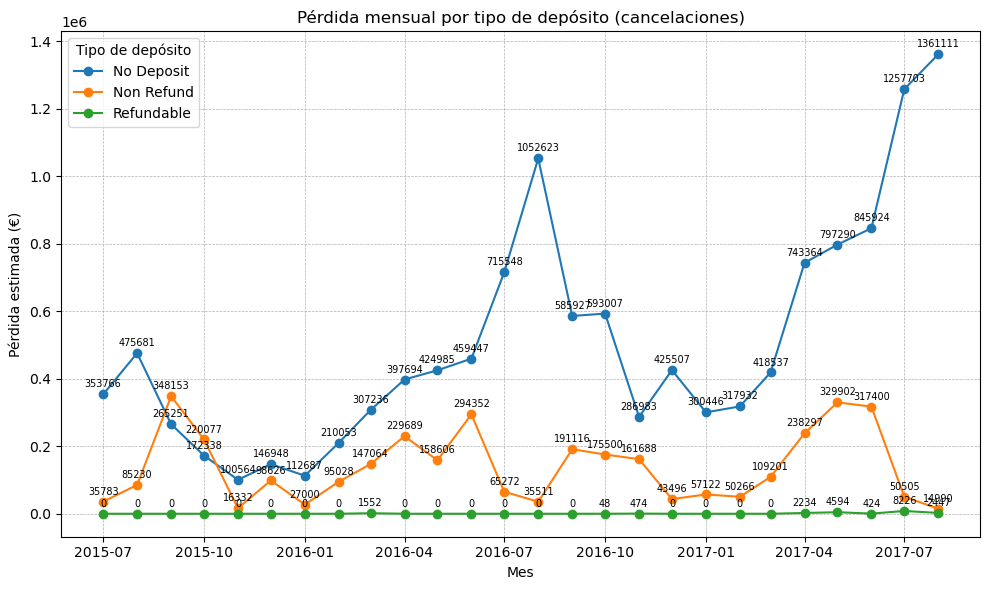

In [75]:
# %% [markdown]
# ## 3. Pérdida mensual desglosada por tipo de depósito

# %%
# Aseguramos etiqueta de depósito
df_canc['deposit_type'] = df_canc['deposit_type'].astype(str)

# Agrupamos por mes y deposit_type
monthly_loss_dep = (
    df_canc
    .groupby([df_canc['arrival_date'].dt.to_period('M'), 'deposit_type'])['loss']
    .sum()
    .unstack('deposit_type')
    .fillna(0)
    .to_timestamp()
)

# %%
# Gráfico de línea por depósito
fig, ax = plt.subplots()
for dep in monthly_loss_dep.columns:
    ax.plot(monthly_loss_dep.index, monthly_loss_dep[dep],
            marker='o', label=dep)
ax.set_title('Pérdida mensual por tipo de depósito (cancelaciones)')
ax.set_xlabel('Mes')
ax.set_ylabel('Pérdida estimada (€)')
ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend(title='Tipo de depósito')

# Anotamos cada punto por curva
for dep in monthly_loss_dep.columns:
    for x, y in zip(monthly_loss_dep.index, monthly_loss_dep[dep]):
        ax.annotate(f"{y:.0f}", (x, y),
                    textcoords="offset points", xytext=(0,5),
                    ha='center', fontsize=7)
plt.tight_layout()
plt.show()


In [77]:
# Código para realizar los tests uno por uno

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['mes'] = df['arrival_date'].dt.month
# Calculamos la tasa de cancelación mensual para regresión
monthly_rate = df.groupby('mes')['is_canceled'].mean()

# 1) Chi‑cuadrado de independencia (mes × cancelación)
ct = pd.crosstab(df['mes'], df['is_canceled'])
chi2, p_chi, dof, expected = stats.chi2_contingency(ct)
print("=== Chi‑cuadrado de independencia ===")
print(f"Chi2 = {chi2:.2f}, p‑valor = {p_chi:.4f}\n")

# 2) ANOVA unifactorial sobre tasa de cancelación
groups = [grp['is_canceled'].values for _, grp in df.groupby('mes')]
f_stat, p_anova = stats.f_oneway(*groups)
print("=== ANOVA unifactorial ===")
print(f"F = {f_stat:.2f}, p‑valor = {p_anova:.4f}\n")

# 3) Prueba de tendencia: Kendall Tau
#tau, p_tau = stats.kendalltau(monthly_rate.index, monthly_rate.values)
#print("=== Tendencia (Kendall Tau) ===")
#print(f"Tau = {tau:.3f}, p‑valor = {p_tau:.4f}\n")

# 4) Regresión lineal simple sobre tasa vs. mes
X = sm.add_constant(monthly_rate.index)
model = sm.OLS(monthly_rate.values, X).fit()
print("=== Regresión lineal sobre tasa vs. mes ===")
print(model.summary())


=== Chi‑cuadrado de independencia ===
Chi2 = 542.76, p‑valor = 0.0000

=== ANOVA unifactorial ===
F = 49.56, p‑valor = 0.0000

=== Regresión lineal sobre tasa vs. mes ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3627
Date:                Thu, 01 May 2025   Prob (F-statistic):              0.560
Time:                        23:35:08   Log-Likelihood:                 23.319
No. Observations:                  12   AIC:                            -42.64
Df Residuals:                      10   BIC:                            -41.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err       

/home/reboot-student/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [79]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import warnings


df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['mes'] = df['arrival_date'].dt.month

# 2) Tasa mensual de cancelación
monthly_rate = df.groupby('mes')['is_canceled'].mean()

# 3) Chi-cuadrado mes × cancelación
ct = pd.crosstab(df['mes'], df['is_canceled'])
chi2, p_chi, dof, exp = stats.chi2_contingency(ct)
print("Chi2 test:", chi2, "p-valor:", p_chi)

# 4) ANOVA unifactorial
groups = [g['is_canceled'].values for _, g in df.groupby('mes')]
F, p_anova = stats.f_oneway(*groups)
print("ANOVA F-stat:", F, "p-valor:", p_anova)

# 5) Prueba de tendencia (Kendall)
tau, p_tau = stats.kendalltau(monthly_rate.index, monthly_rate.values)
print("Kendall Tau:", tau, "p-valor:", p_tau)

# 6) Regresión lineal de tasa vs mes
X = sm.add_constant(monthly_rate.index)
model = sm.OLS(monthly_rate.values, X).fit()

#  ——> Aquí filtramos el warning de kurtosistest:
warnings.filterwarnings(
    "ignore",
    message=".*kurtosistest only valid for n>=20.*",
    category=UserWarning
)

print(model.summary())


Chi2 test: 542.7641641398702 p-valor: 2.3974650825962615e-109
ANOVA F-stat: 49.564998561134935 p-valor: 1.3180254277582658e-109
Kendall Tau: 0.0606060606060606 p-valor: 0.8405883696421891
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3627
Date:                Thu, 01 May 2025   Prob (F-statistic):              0.560
Time:                        23:36:22   Log-Likelihood:                 23.319
No. Observations:                  12   AIC:                            -42.64
Df Residuals:                      10   BIC:                            -41.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef 

A partir de los resultados:

    Chi-cuadrado de independencia

        Estadístico: χ² = 542.76, p-valor < 0.0001

        Interpretación: Rechazamos la H₀ (“la probabilidad de cancelación es la misma en todos los meses”). Hay evidencia muy fuerte de que el mes del año y la probabilidad de cancelación están asociados.

    ANOVA unifactorial

        F = 49.56, p-valor < 0.0001

        Interpretación: También aquí rechazamos la H₀ (“las medias de la tasa de cancelación son iguales para todos los meses”). Los promedios de cancelación difieren significativamente entre meses.

    Tendencia (Kendall Tau)

        Tau = 0.061, p-valor = 0.8406

        Interpretación: No hay evidencia de una tendencia monótona (ni creciente ni decreciente) en la tasa de cancelación a lo largo del año.

    Regresión lineal tasa vs. mes

        Intercepto ≈ 0.355 (p<0.001)

        Pendiente ≈ 0.0019 (p = 0.56)

        R² ≈ 0.035

        Interpretación: El coeficiente de mes no es significativo (p=0.56), confirmando que no existe una tendencia lineal clara en la tasa de cancelación a lo largo de los meses.

#### Conclusión global
#### Hay variación estacional: ciertas épocas del año tienen cancelaciones muy distintas (Chi-cuadrado y ANOVA lo confirman).
#### Sin embargo, no existe una tendencia lineal ni monótona de aumento o disminución de cancelaciones mes a mes durante el período analizado.
#### En la práctica: deberías centrarte en identificar meses pico y quizá investigar qué factores (vacaciones, temporada alta, políticas de precios) explican esas diferencias estacionales, más que buscar un patrón de crecimiento o decrecimiento a lo largo del tiempo.